# Imports

In [4]:
import glob
import os
import re
import shutil

import pandas as pd
import scanpy as sc
import sig_utils
from joblib import Parallel, delayed
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from tqdm import tqdm

pd.options.display.max_rows = 500

%load_ext autoreload
%autoreload 2

## Def Describe

In [5]:
%%file pandas_utils.py

def describe(df, random=False):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    if random:
        print('--- Random subset ---')
        display(df.sample(5))

Overwriting pandas_utils.py


In [6]:
from pandas_utils import describe

## Read one2one h5ad

In [7]:
adata = sc.read(
#     "/home/phoenix/data_sm/code/immune-evolution/h5ads/human-lemur-mouse-bat__lung_only_copy.h5ad"
    "/home/olga/data_sm/immune-evolution/h5ads/human-lemur-mouse-bat/human-lemur-mouse-bat__lung_only.h5ad"
)
adata.obs = adata.obs.reset_index().set_index('cell_id')
print(adata)
adata.obs.head()

AnnData object with n_obs × n_vars = 126745 × 10560
    obs: 'index', 'age', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'free_annotation', 'individual', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'tissue', 'narrow_group', 'broad_group', 'compartment_group', 'compartment_narrow', 'channel_cleaned', 'batch', 'n_genes', 'n_counts', 'species_batch_v2', 'compartment_broad', 'compartment_broad_narrow', 'compartment_species', 'compartment_narrow_species', 'common_individual_id'
    var: 'bat__gene_name', 'mouse_lemur__gene_name-bat', 'mouse__gene_name-bat', 'mouse_lemur__gene_name_x-hlm', 'mouse__gene_name_x-hlm', 'gene_ids-lemur-hlm', 'n_cells-mouse-hlm', 'mouse_lemur__gene_name_y-hlm', 'mouse__gene_name_y-hlm'


,index,age,cell_barcode,cell_ontology_class,cell_ontology_id,channel,free_annotation,individual,sample,sequencing_run,...,channel_cleaned,batch,n_genes,n_counts,species_batch_v2,compartment_broad,compartment_broad_narrow,compartment_species,compartment_narrow_species,common_individual_id
cell_id,,,,,,,,,,,,,,,,,,,,,
P2_1__AAACCTGAGAAACCAT,P2_1_AAACCTGAGAAACCAT-human-hlm,46y,AAACCTGAGAAACCAT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AAATGCCAGATGAGAG,P2_1_AAATGCCAGATGAGAG-human-hlm,46y,AAATGCCAGATGAGAG,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGATCCCT,P2_1_AACACGTTCGATCCCT-human-hlm,46y,AACACGTTCGATCCCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACACGTTCGCACTCT,P2_1_AACACGTTCGCACTCT-human-hlm,46y,AACACGTTCGCACTCT,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2
P2_1__AACCATGCAGCTCGCA,P2_1_AACCATGCAGCTCGCA-human-hlm,46y,AACCATGCAGCTCGCA,capillary endothelial cell,nan,P2_1,Capillary Aerocyte,patient_2,distal 2,180607_A00111_0155_BHFCWYDMXX,...,P2_1,NaN,NaN,NaN,hlm,endothelial: Capillary,endothelial: Capillary: Capillary Aerocyte,endothelial: human,endothelial: Capillary Aerocyte: human,human_patient_2


In [8]:
adata.obs.species.value_counts()

Human          57353
Mouse lemur    36934
Mouse          23802
Bat             8656
Name: species, dtype: int64

In [9]:
adata.obs.query('species == "Mouse"').groupby(["age", "channel"], observed=True).size()

age  channel           
18m  MACA_18m_F_LUNG_50     320
     MACA_18m_F_LUNG_51    1138
     MACA_18m_M_LUNG_52    1573
     MACA_18m_M_LUNG_53    1256
21m  MACA_21m_F_LUNG_54    1312
     MACA_21m_F_LUNG_55    1526
30m  10X_P1_6              7728
     10X_P1_14             1565
     10X_P2_5               920
     10X_P3_0               496
1m   10X_P5_13             1043
     10X_P5_14             1384
3m   10X_P7_8               348
     10X_P7_9               979
     10X_P8_12              578
     10X_P8_13             1636
dtype: int64

## Set shared celltypes

In [10]:
SHARED_CELLTYPES = ['Alveolar Epithelial Type 2',
 'B cell',
 'Capillary',
 'Dendritic',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'Natural Killer T cell',
 'Smooth Muscle and Myofibroblast',
 'T cell']
len(SHARED_CELLTYPES)

10

In [11]:
adata_shared = adata[adata.obs.broad_group.isin(SHARED_CELLTYPES)]
adata_shared

/home/olga/miniconda3/envs/immune-evolution/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 89795 × 10560
    obs: 'index', 'age', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'free_annotation', 'individual', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'tissue', 'narrow_group', 'broad_group', 'compartment_group', 'compartment_narrow', 'channel_cleaned', 'batch', 'n_genes', 'n_counts', 'species_batch_v2', 'compartment_broad', 'compartment_broad_narrow', 'compartment_species', 'compartment_narrow_species', 'common_individual_id'
    var: 'bat__gene_name', 'mouse_lemur__gene_name-bat', 'mouse__gene_name-bat', 'mouse_lemur__gene_name_x-hlm', 'mouse__gene_name_x-hlm', 'gene_ids-lemur-hlm', 'n_cells-mouse-hlm', 'mouse_lemur__gene_name_y-hlm', 'mouse__gene_name_y-hlm'

In [12]:
CELL_IDS_TO_USE = set(adata_shared.obs.index)
len(CELL_IDS_TO_USE)

89795

In [13]:
# adata_shared.obs.query('species == "Mouse"').groupby(
#     ["channel", "broad_group"], observed=True
# ).size()

In [14]:
adata_shared.obs.query('species == "Mouse"').groupby(
    ['age', "channel"],
    observed=True,
).broad_group.nunique()

age  channel           
18m  MACA_18m_F_LUNG_50     9
     MACA_18m_F_LUNG_51    10
     MACA_18m_M_LUNG_52    10
     MACA_18m_M_LUNG_53    10
21m  MACA_21m_F_LUNG_54    10
     MACA_21m_F_LUNG_55    10
30m  10X_P1_6               8
     10X_P1_14              9
     10X_P2_5               9
     10X_P3_0               9
1m   10X_P5_13             10
     10X_P5_14              9
3m   10X_P7_8              10
     10X_P7_9              10
     10X_P8_12              8
     10X_P8_13              8
Name: broad_group, dtype: int64

## Set signature outdir

In [15]:
sig_outdir_base = '/mnt/ibm_sm/olga/immune-evolution/kmer-signatures'

In [16]:
ls -lha $sig_outdir_base

total 11K
drwxr-xr-x 7 olga czb 4.0K Mar  5 12:02 ./
drwxrwxr-x 8 olga czb 8.0K Mar 16 10:36 ../
drwxr-xr-x 4 olga czb 4.0K Feb 28 09:53 0--mouse2mouse/
drwxr-xr-x 8 olga czb 4.0K Mar 18 16:12 1--train-mouse/
drwxr-xr-x 8 olga czb 4.0K Mar  3 14:50 2--test-human/
drwxr-xr-x 9 olga czb 4.0K Mar  5 17:42 3--test-bat/
drwxr-xr-x 8 olga czb 4.0K Mar  5 12:06 4--test-lemur/


In [17]:
rm -rf $sig_outdir_base/mouse/single-cell

## sketch ids of interest

In [18]:
alpha_ksizes = (("DNA", 21), ("protein", 30), ("dayhoff", 51))
sketch_ids = [sig_utils.make_sketch_id(alpha=alpha, ksize=ksize, style='scaled', value=10) for alpha, ksize in alpha_ksizes]
sketch_ids

['alphabet-DNA__ksize-21__scaled-10',
 'alphabet-protein__ksize-30__scaled-10',
 'alphabet-dayhoff__ksize-51__scaled-10']

In [19]:
nucleotide_sketch_ids = sketch_ids[:1]
nucleotide_sketch_ids

['alphabet-DNA__ksize-21__scaled-10']

In [20]:
peptide_sketch_ids = sketch_ids[1:]
peptide_sketch_ids

['alphabet-protein__ksize-30__scaled-10',
 'alphabet-dayhoff__ksize-51__scaled-10']

In [21]:
import sig_reorg

## Set output folder names

In [22]:
train_dir = "/home/olga/data_sm/immune-evolution/kmer-signatures/1--train-mouse"

# --- Training data directories --- #
train_0_fastas = os.path.join(train_dir, "0--protein-coding-fastas")
train_1_single_cells = os.path.join(
    train_dir, "1--single-cell-sigs"
)
train_2_merged_celltype = os.path.join(
    train_dir, "2--merged-celltype-sigs"
)
train_3_merged_celltype_remove_common = os.path.join(
    train_dir, "3--merged-celltype-remove-common-kmers"
)
train_4_celltype_sbts = os.path.join(
    train_dir, "4--celltype-sbt-dbts"
)

dirs = (
    train_dir,
    train_0_fastas,
    train_1_single_cells,
    train_2_merged_celltype,
    train_3_merged_celltype_remove_common,
    train_4_celltype_sbts,
)
for outdir in dirs:
    if not os.path.exists(outdir):
        os.makedirs(outdir)

# Mouse

## Single cell fastas

In [47]:
! ls -lha $sig_outdir_base

total 11K
drwxr-xr-x  6 olga czb 4.0K Feb 28 09:33 .
drwxrwxr-x 81 olga czb 8.0K Feb 28 09:02 ..
drwxr-xr-x  3 olga czb 4.0K Feb 28 09:33 0--mouse2mouse
drwxr-xr-x  3 olga czb 4.0K Feb 28 09:29 1--train-mouse
drwxr-xr-x  2 olga czb 4.0K Feb 28 09:17 mouse
drwxr-xr-x  3 olga czb 4.0K Feb 27 09:59 mouse2mouse


In [23]:
mouse_train_dir = os.path.join(sig_outdir_base, "1--train-mouse")

mouse_kmermaid_base = '/home/olga/data_sm/immune-evolution/pipeline-results/mouse/kmermaid/lung--mouse--remove-ribo/'

bat_kmermaid_base = '/home/olga/data_sm/immune-evolution/pipeline-results/bat/kmermaid/ksize_8'

mouse_train_0_fastas = os.path.join(mouse_train_dir, "0--protein-coding-fastas")
mouse_fasta_input_dir = os.path.join(mouse_kmermaid_base, "translate")


## Single cell signatures

In [24]:
mouse_peptide_sketch_dir = os.path.join(
    bat_kmermaid_base,
    "sketches_peptide_handmade_mouse_merged_remove_ribosomal_dissociation_all_mouse_cells",
)
mouse_nucleotide_sketch_dir = os.path.join(mouse_kmermaid_base, 'sketches_nucleotide_handmade_per_mouse_remove_ribosomal')

## Sourmash sig describe

In [30]:
! sourmash sig describe \
    --csv $train_3_merged_celltype_remove_common/sourmash_sig_describe.csv \
    $train_3_merged_celltype_remove_common/*/*.sig


== This is sourmash version 4.0.0. ==
== Please cite Brown and Irber (2016), doi:10.21105/joss.00027. ==

---<<<rs/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig.sig'
signature filename: /home/olga/data_sm/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig.sig
signature: Alveolar Epithelial Type 2
source file: ** no name **
md5: 029549a156b208f1d5f872b03345ebea
k=17 molecule=dayhoff num=0 scaled=10 seed=42 track_abundance=1
size: 73584
signature license: CC0

<<<rs/alphabet-dayhoff__ksize-51__scaled-10/alveolar_epithelial_type_2.sig.sig'
---<<<pe-remove-common-kmers/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig.sig'
signature filename: /home/olga/data_sm/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers/alphabet-dayhoff__ksize-51__scaled-10/b_cell.sig.sig
signature: B cell
source file: ** no name **
md5: a454986c0b5f04c5

In [31]:
train_3_merged_celltype_remove_common

'/home/olga/data_sm/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers'

In [32]:
sig_describe = pd.read_csv(
    os.path.join(train_3_merged_celltype_remove_common, "sourmash_sig_describe.csv")
)
describe(sig_describe)

(30, 12)
--- First 5 entries ---


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license
0,/home/olga/data_sm/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0
1,/home/olga/data_sm/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0
2,/home/olga/data_sm/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0
3,/home/olga/data_sm/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0
4,/home/olga/data_sm/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0


### Plot number of hashes per cell type

#### Assign figure folder

In [33]:
figure_folder = (
    "/home/olga/googledrive/ImmuneEvolution/figures/mouse_celltype_db"
)
! mkdir -p $figure_folder

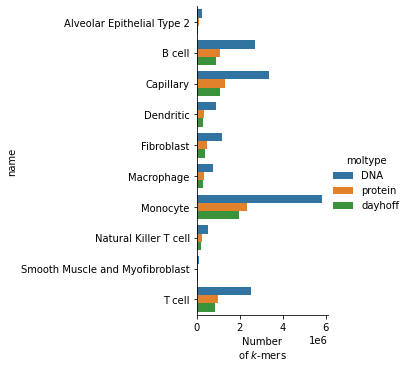

In [34]:
g = sns.catplot(
    data=sig_describe,
    hue="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    hue_order=["DNA", "protein", "dayhoff"],
)
g.set(xlabel='Number\nof $k$-mers')
pdf = os.path.join(
    figure_folder,
    "barplot__n_kmers__per_celltype__hue-alphabet.pdf",
)
g.savefig(pdf)

  0%|          | 0/30 [407:57:41<?, ?it/s]


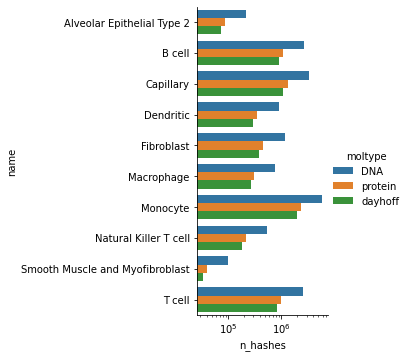

In [123]:
g = sns.catplot(
    data=sig_describe,
    hue="moltype",
    x="n_hashes",
    y="name",
    kind="bar",
    hue_order=["DNA", "protein", "dayhoff"],
)
g.set(xscale='log')

In [126]:
sig_describe.set_index('moltype').groupby('name').n_hashes.apply(lambda x: x['protein']/x['DNA'])

name
Alveolar Epithelial Type 2         0.395986
B cell                             0.400091
Capillary                          0.395343
Dendritic                          0.400139
Fibroblast                         0.398620
Macrophage                         0.415258
Monocyte                           0.400474
Natural Killer T cell              0.405532
Smooth Muscle and Myofibroblast    0.398027
T cell                             0.395208
Name: n_hashes, dtype: float64

In [127]:
sig_describe.set_index('moltype').groupby('name').n_hashes.apply(lambda x: x['dayhoff']/x['protein'])

name
Alveolar Epithelial Type 2         0.853762
B cell                             0.824740
Capillary                          0.808785
Dendritic                          0.829933
Fibroblast                         0.813068
Macrophage                         0.878989
Monocyte                           0.841046
Natural Killer T cell              0.830216
Smooth Muscle and Myofibroblast    0.831107
T cell                             0.835193
Name: n_hashes, dtype: float64

# Plot sourmash sig describe `n_hashes` vs number of cells per celltype

## Read one2one 5had

In [7]:
ls -lh /home/olga/data_sm/immune-evolution/data-objects/human-lemur-mouse-bat/

total 3.8G
-rw-r--r-- 1 olga czb 974M Oct 15 09:28 basename
-rw-r--r-- 1 olga czb 974M Oct 21 11:45 human-lemur-mouse-bat__lung_only.h5ad
-rw-r--r-- 1 olga czb 883M Oct 21 11:52 human-lemur-mouse-bat__lung_only__preprocessed_bbknn.h5ad
-rw-r--r-- 1 olga czb 972M Nov  5 07:54 human-lemur-mouse-bat__lung_only__with_qc_metrics.h5ad


In [20]:
%%time

adata = sc.read(
    os.path.join(
        "/home/olga/data_sm/immune-evolution/data-objects/human-lemur-mouse-bat/",
        "human-lemur-mouse-bat__lung_only.h5ad",
    )
)
adata.obs = adata.obs.set_index("cell_id")
adata

CPU times: user 549 ms, sys: 872 ms, total: 1.42 s
Wall time: 9.56 s


AnnData object with n_obs × n_vars = 126745 × 10560
    obs: 'age', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'free_annotation', 'individual', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'tissue', 'narrow_group', 'broad_group', 'compartment_group', 'compartment_narrow', 'channel_cleaned', 'batch', 'n_genes', 'n_counts', 'species_batch_v2', 'compartment_broad', 'compartment_broad_narrow', 'compartment_species', 'compartment_narrow_species', 'common_individual_id'
    var: 'bat__gene_name', 'mouse_lemur__gene_name-bat', 'mouse__gene_name-bat', 'mouse_lemur__gene_name_x-hlm', 'mouse__gene_name_x-hlm', 'gene_ids-lemur-hlm', 'n_cells-mouse-hlm', 'mouse_lemur__gene_name_y-hlm', 'mouse__gene_name_y-hlm'

In [21]:
adata.obs.species.value_counts()

Human          57353
Mouse lemur    36934
Mouse          23802
Bat             8656
Name: species, dtype: int64

In [28]:
adata_mouse = adata[(adata.obs.species == "Mouse") & adata.obs.broad_group.isin(SHARED_CELLTYPES)]
adata_mouse

View of AnnData object with n_obs × n_vars = 21256 × 10560
    obs: 'age', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'free_annotation', 'individual', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'tissue', 'narrow_group', 'broad_group', 'compartment_group', 'compartment_narrow', 'channel_cleaned', 'batch', 'n_genes', 'n_counts', 'species_batch_v2', 'compartment_broad', 'compartment_broad_narrow', 'compartment_species', 'compartment_narrow_species', 'common_individual_id'
    var: 'bat__gene_name', 'mouse_lemur__gene_name-bat', 'mouse__gene_name-bat', 'mouse_lemur__gene_name_x-hlm', 'mouse__gene_name_x-hlm', 'gene_ids-lemur-hlm', 'n_cells-mouse-hlm', 'mouse_lemur__gene_name_y-hlm', 'mouse__gene_name_y-hlm'

In [32]:
n_cells = adata_mouse.obs.broad_group.value_counts()
n_cells.name = 'n_cells'
n_cells

Monocyte                           10319
Capillary                           2255
Fibroblast                          2016
T cell                              1663
Dendritic                           1469
B cell                              1457
Macrophage                          1319
Natural Killer T cell                406
Smooth Muscle and Myofibroblast      230
Alveolar Epithelial Type 2           122
Name: n_cells, dtype: int64

In [33]:
train_3_merged_celltype_remove_common = '/home/olga/data_sm/immune-evolution/kmer-signatures/1--train-mouse/3--merged-celltype-remove-common-kmers'
sig_describe = pd.read_csv(
    os.path.join(train_3_merged_celltype_remove_common, "sourmash_sig_describe.csv")
)
describe(sig_describe)

(30, 12)
--- First 5 entries ---


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license
0,/home/olga/data_sm/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0
1,/home/olga/data_sm/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0
2,/home/olga/data_sm/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0
3,/home/olga/data_sm/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0
4,/home/olga/data_sm/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0


In [35]:
sig_describe_n_cells = sig_describe.join(n_cells, on='name')
describe(sig_describe_n_cells)

(30, 13)
--- First 5 entries ---


,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,n_cells
0,/home/olga/data_sm/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0,122
1,/home/olga/data_sm/immune-evolution/kmer-signa...,a454986c0b5f04c5b2545ec0edc6dcbf,17,dayhoff,0,10,897727,42,1,B cell,** no name **,CC0,1457
2,/home/olga/data_sm/immune-evolution/kmer-signa...,86fb2933635379e6e0939bbc8f229693,17,dayhoff,0,10,1066948,42,1,Capillary,** no name **,CC0,2255
3,/home/olga/data_sm/immune-evolution/kmer-signa...,1d8c93a9f643c521717d9181143ad85e,17,dayhoff,0,10,295882,42,1,Dendritic,** no name **,CC0,1469
4,/home/olga/data_sm/immune-evolution/kmer-signa...,15adfc8520d4c2ee5160f49da634ff91,17,dayhoff,0,10,375364,42,1,Fibroblast,** no name **,CC0,2016


In [50]:
sig_describe_n_cells.query('name == "Alveolar Epithelial Type 2"')

,signature_file,md5,ksize,moltype,num,scaled,n_hashes,seed,with_abundance,name,filename,license,n_cells,n_hashes_log10,n_cells_log10
0,/home/olga/data_sm/immune-evolution/kmer-signa...,029549a156b208f1d5f872b03345ebea,17,dayhoff,0,10,73584,42,1,Alveolar Epithelial Type 2,** no name **,CC0,122,4.866783,2.08636
10,/home/olga/data_sm/immune-evolution/kmer-signa...,c6c60fe0f33187f439c8d5c0544a7b00,21,DNA,0,10,217654,42,1,Alveolar Epithelial Type 2,** no name **,CC0,122,5.337767,2.08636
20,/home/olga/data_sm/immune-evolution/kmer-signa...,92f96428169aa335c3beeb6d3a459a10,10,protein,0,10,86188,42,1,Alveolar Epithelial Type 2,** no name **,CC0,122,4.935447,2.08636


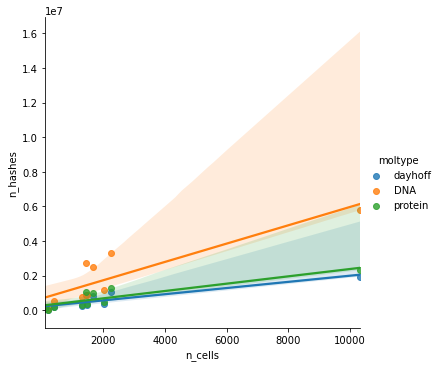

In [45]:
g = sns.lmplot(data=sig_describe_n_cells, x='n_cells', y='n_hashes', hue='moltype')


### Add log10 of `n_hashes` and `n_cells`

In [48]:
sig_describe_n_cells['n_hashes_log10'] = np.log10(sig_describe_n_cells.n_hashes)
sig_describe_n_cells['n_cells_log10'] = np.log10(sig_describe_n_cells.n_cells)

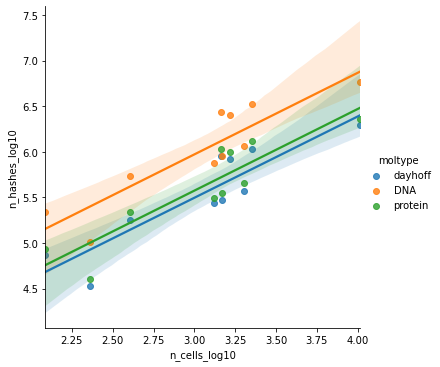

In [49]:
g = sns.lmplot(data=sig_describe_n_cells, x='n_cells_log10', y='n_hashes_log10', hue='moltype')
